In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#FIX: take into account daylight savings time like in Example 11.1
#ignoring for now

#latitude = 46.77 #(in degrees)
#longitude = 117.2 #(in degrees)
latitude = 22.9068
longitude = 43.1729
standard_meridian = 120.0 #(in degrees)
day_of_year = 181 #equivalent to June 30

#FIX: figure out where this came from in old raytracer
kSOLAR_constant = 2600

hours_before_decimal = "9:45"
(hh, mm) = hours_before_decimal.split(':')
hour_of_day = int(hh) + (int(mm) * (1 / 60))
#print("hour_of_day: ", hour_of_day)


######

def sun_calcs(latitude, longitude, standard_meridian, day_of_year, hour_of_day):
    solar_noon = 12
    
    #LOCAL MERIDIAN IN DEGREES
    local_meridian = standard_meridian - longitude
    #print("local meridian")
    #print(local_meridian)

    radians_per_degree = np.pi / 180

    radians_rotation_per_hour = 15 * radians_per_degree
    axial_tilt = 13.5 * radians_per_degree

    phi = latitude * radians_per_degree

    #from sun model code in HackMD: https://hackmd.io/98rj0V82RSyrDavaFxQbEg
    number_days_after_dec_solstice = day_of_year + 10

    omega = 360.0 * (number_days_after_dec_solstice / 365.0) * radians_per_degree
    delta = -axial_tilt * math.cos(omega)
    tau = (hour_of_day - solar_noon) * radians_rotation_per_hour

    #equation of time (in hours)
    J = day_of_year
    f = 279.575 + (0.9856 * J)

    f_rad = math.radians(f)
    part_1 = math.sin(f_rad) * -104.7

    f2 = f * 2
    f2_rad = math.radians(f2)
    part_2 = math.sin(f2_rad) * 596.2

    f3 = f * 3
    f3_rad = math.radians(f3)
    part_3 = math.sin(f3_rad) * 4.3

    f4 = f * 4
    f4_rad = math.radians(f4)
    part_4 = math.sin(f4_rad) * 12.7

    part_5 = math.cos(f_rad) * 429.3

    part_6 = math.cos(f2_rad) * 2.0

    part_7 = math.cos(f3_rad) * 19.3

    all_together = part_1 + part_2 + part_3 - part_4 - part_5 - part_6 + part_7

    equation_of_time = all_together / 3600
    #print("equation of time")
    #print(equation_of_time)

    longitudinal_correction = local_meridian / 15 #in hours
    #print("logitudinal correction")
    #print(longitudinal_correction)

    #time of solar noon (in hours)
    t0 = 12 - longitudinal_correction - equation_of_time
    #print("t0")
    #print(t0)

    #solar declination
    #should range from +23.45 degrees at summer solstice to -23.45 degrees at winter solstice
    times_j = 0.9856 * J
    inside_sine = 356.6 + times_j
    inside_sine_rad = math.radians(inside_sine)

    inner_sin = math.sin(math.radians(inside_sine))

    additions = 278.97 + times_j + (1.9165 * inner_sin)
    additions_rad = math.radians(additions)
    sin_of_adds = math.sin(additions_rad)
    times_const = 0.39785 * sin_of_adds

    final_in_rad = math.asin(times_const)

    solar_declination = math.degrees(final_in_rad)
    #print("solar declination")
    #print(solar_declination)

    #calculate zenith angle

    latitude_rad = math.radians(latitude)
    solar_declination_rad = math.radians(solar_declination)

    sin_1 = math.sin(latitude_rad)
    sin_2 = math.sin(solar_declination_rad)
    
    cos_1 = math.cos(latitude_rad)
    cos_2 = math.cos(solar_declination_rad)

    inside_cos = 15 * (hour_of_day - t0)
    inside_cos_rad = math.radians(inside_cos)

    cos_3 = math.cos(inside_cos_rad)

    before_arccos = (sin_1 * sin_2) + (cos_1 * cos_2 * cos_3)
    
    zenith_angle_rad = math.acos(before_arccos)

    zenith_angle = math.degrees(zenith_angle_rad)
    #print("zenith angle")
    #print(zenith_angle)

    ninety_six_rad = math.radians(96)
    first_cos = math.cos(ninety_six_rad)

    sins = math.sin(latitude_rad) * math.sin(solar_declination_rad)

    cosines = math.cos(latitude_rad) * math.cos(solar_declination_rad)

    equation = (first_cos - sins) / cosines
    
    #FIX: get error at certain latitudes/longitudes
    equation_acos = math.acos(equation)

    half_daylength = math.degrees(equation_acos)
    #print("half daylength")
    #print(half_daylength)

    time_sunrise = solar_noon - (half_daylength / 15)
    #print("time sunrise")
    #print(time_sunrise)

    hours = half_daylength * (1 / 15)
    #print("hours")
    #print(hours)

    first_twilight = t0 - hours
    #print("first twilight")
    #print(first_twilight)

    daylength = 2 * hours
    #print("daylength")
    #print(daylength)

    #FIX: including a +1 to take care of daylight savings time for now
    time_sunrise = first_twilight + longitudinal_correction + equation_of_time + 1
    #print("time sunrise")
    #print(time_sunrise)
    
    #return zenith_angle
    return {'zenith': zenith_angle, 'half_daylength': half_daylength, 'time_sunrise': time_sunrise, 'hours': hours,'first_twilight': first_twilight, 'daylength': daylength}

In [2]:
sun_calcs(latitude, longitude, standard_meridian, day_of_year, hour_of_day)

{'zenith': 38.6924118268674,
 'half_daylength': 107.7494835163534,
 'time_sunrise': 5.816701098909774,
 'hours': 7.183298901090226,
 'first_twilight': -0.24711249379361178,
 'daylength': 14.366597802180452}

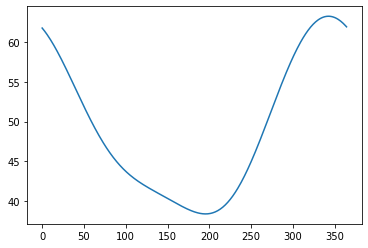

In [3]:
vals = []
for day in np.arange(365):
    vals.append(sun_calcs(latitude, longitude, standard_meridian, day, hour_of_day))
df = pd.DataFrame(vals)
plt.plot("zenith", data=df)
#vals

In [4]:
def calculation_PPFD(latitude, longitude, standard_meridian, day_of_year, hour_of_day):

    solar_noon = 12
    
    h = 15 * (hour_of_day - solar_noon) / 180 * np.pi
    print(h)

    derta = -23.45 * np.cos(2 * np.pi * (day_of_year + 10) / 365) / 180 * np.pi
    phi = latitude / 180 * np.pi
    #FIX: double check the arcsin calculations here
    thetas = np.arcsin((np.cos(h) * np.cos(derta) * np.cos(phi) + np.sin(derta) * np.sin(phi)))

    temp = (np.sin(derta) * np.cos(phi) - np.cos(h) * np.cos(derta) * np.sin(phi)) / np.cos(thetas)

    phys = 0

    if temp >= 1:
        phys = 0
    else:
        if temp < -1:
            temp = -1

    if h > 0:
        phys = -phys

    elevationAngle = thetas
    azimuthAngle = phys

    #Vect v
    #v.x = cos(elevationAngle) * cos(azimuthAngle)
    #v.y = cos(elevationAngle) * sin(azimuthAngle)
    #v.z = -sin(elevationAngle)

    ppfd = kSOLAR_constant * np.power(1.0, (1 / np.sin(elevationAngle))) * np.sin(elevationAngle)

    #PPFD_dir_light_per_triangle[current_pixel] = ppfd


In [5]:
sun_calcs(latitude, longitude, standard_meridian, day_of_year, hour_of_day)
calculation_PPFD(latitude, longitude, standard_meridian, day_of_year, hour_of_day)

-0.5890486225480862


In [6]:
startHour = 11
endHour = 12
hourInterval = 1
atmosphericTransmittance = 0.7

def calculation_PPFD_climate(startHour, endHour, hourInterval, day_of_year, latitude):
    solarTimeNoon = 12
    
    #num = (int)((endHour - startHour) / hourInterval)
    hour = startHour + (i * hourInterval)
    DERTA = -23.45 * np.cos(2 * np.pi * (day_of_year + 10) / 365) / 180 * np.pi
    
    #latitude
    PHI = latitude / 180 * np.pi
    TSN = solarTimeNoon
    
    #time angle
    h = 15 * (hour_of_day - TSN) / 180 * np.pi
    THETAS = math.asin((math.cos(h) * math.cos(DERTA) * math.cos(PHI) + math.sin(DERTA) * math.sin(PHI)))
    
    temp = (float)(math.sin(DERTA) * math.cos(PHI) - math.cos(h) * math.cos(DERTA) * math.sin(PHI)) / cos(THETAS)
    
    PHYS = 0
    if temp >= 1:
        PHYS = 0
    elif temp <= -1:
        PHYS = np.pi
    else:
        PHYS = math.acos(temp)
        
    if h > 0:
        PHYS = np.pi - PHYS
        
    elevationAngle = THETAS
    azimuthAngle = PHYS
    
    if elevationAngle >= 0:
        #Vect v
        #v.x = cos(elevationAngle) * cos(azimuthAngle)
        #v.y = cos(elevationAngle) * sin(azimuthAngle)
        #v.z = -sin(elevationAngle)
        
        #direct_light_d_list.push_back(v)
        
        #DIRECT LIGHT
        PPFD1 = kSOLAR_constant * np.power(atmosphericTransmittance, 1 / math.sin(elevationAngle)) * math.sin(elevationAngle)
        #DIFFUSE LIGHT
        #PPFD2 = 0.5 * kSOLAR_constant * (1 - np.power(atmosphericTransmittance, 1 / math.sin(elevationAngle))) * math.sin(elevationAngle)
        
        #ppfd_direct_light.push_back(PPFD1)
        #ppfd_diffuse_light.push_back(PPFD2)
    else: 
        #Vect v
        #v.x = 0
        #v.y = 0
        #v.z = 0
        #direct_light_d_list.push_back(v)
        
        PPFD1 = 0
        PPFD2 = 0
        
        #ppfd_direct_light.push_back(PPFD1)
        #ppfd_diffuse_light.push_back(PPFD2)
        

In [7]:
def sun_energy_total():
    #surface temp of sun
    T = 5800 #Kelvin
    
    #radius of sun
    R = 6.995 * 10**8 #meters
    
    #stefan's constant
    stefan = 5.67 * 10**-8 #Wm^-2K^-4
    
    #equation for thermal energy per second (power) radiated by sun
    power = 4 * np.pi * (R)**2 * stefan * (T)**4 #Watts
    print("total sun energy per second:", power)
    
    #per minute
    energy = power * 60 #Joules
    print("total sun energy per minute:", energy)
    
    #per hour
    #energy_per_hour = power * 60 * 60
    #print(energy_per_hour)
    

In [8]:
sun_energy_total()

total sun energy per second: 3.945302746541945e+26
total sun energy per minute: 2.3671816479251673e+28


In [9]:
#energy of photon = Planck's constant as h * frequency (oscillations per second in Hertz)
#Planck's constant: 6.626 * 10^-34 Js
#single photon = h * C / lamba (in Joules)

#energy (watts * time) --> go through conversion to get units we want (Joules * seconds)

#https://www.youtube.com/watch?v=Zqt3btS1FwE

In [44]:
def power_atmosphere(zenith_angle):

    sun_surface_energy = 6.33 * 10**7 #watts / meter squared

    #equals (6.33 * 10**7 W/m^2)*(surface area of sun) / (4pi)((distance form earth to sun)^2)
    solar_constant = 1367 #watts / meter squared

    #outside of the atmosphere
    extraterrestrial_irradiance = solar_constant * (1 + 0.034 * math.cos((2 * np.pi) * (day_of_year / 265.25)))
    #print(extraterrestrial_irradiance)
    
    cos_zenith_angle = math.cos(zenith_angle)
    #print(cos_zenith_angle)

    #instantaneous power at this time
    power_without_atmosphere = extraterrestrial_irradiance * cos_zenith_angle #watts / meter squared
    #print(power_without_atmosphere)

    #atmospheric effects
    #take into account cloudy vs. sunny
    #rayleigh scattering 

    #equation 2.3: how much air the sun has to go through to get to a point (not taking into account weather/clouds)
    #ranges from 0 to 2 --> amount getting blocked by the atmosphere

    #constants
    radius_of_earth = 6370 #kilometers
    #FIX: need to figure out how to adjust based on location on earth
    thickness_of_atmosphere = 7991 #kilometers 
    #atmospheric effects --> does not take into account various atmospheric effects
    air_mass = (((radius_of_earth / thickness_of_atmosphere) * math.cos(zenith_angle))**2 + (2 * (radius_of_earth / thickness_of_atmosphere) + 1))**.5 - ((radius_of_earth / thickness_of_atmosphere) * math.cos(zenith_angle))
    #print(air_mass)

    half_air_mass = air_mass / 2
    #print(half_air_mass)

    power_with_atmosphere = power_without_atmosphere * half_air_mass #watts / meter squared
    print("power_with_atmosphere: ", power_with_atmosphere)

    return power_with_atmosphere
   

In [45]:
#FIX: pass in zenith_angle from sun_calcs() return statement
power_atmosphere(zenith_angle = 38.692411)

power_with_atmosphere:  453.72832148751365


453.72832148751365

In [68]:
def photons_output(power_with_atmosphere):
    plancks_constant = 6.626 * 10**-34 #Js
    
    sample_wavelength = 635 #nanometers (nm)
    sample_wavelength_meter = sample_wavelength * (1 * 10**-9)
    C = 3.0 * 10**8 #m/s
    frequency = C / sample_wavelength_meter #vibrations per second
    print(frequency)
    
    #single photon = h * C / lamba (in Joules)
    single_photon = plancks_constant * C / frequency
    print(single_photon)
    
    #1 J/(s * m^2) = watt / m^2
    energy_photon = plancks_constant * frequency #Joules
    print(energy_photon)
    
    #calculate number of photons?

In [69]:
photons_output(power_with_atmosphere = 453.728321)

472440944881889.7
4.207510000000001e-40
3.130393700787401e-19
